In [1]:
import ee
import geemap

In [2]:
import ee, datetime    # Google Earth Engine
import pandas as pd
import numpy as np
import folium
import geehydro
from datetime import datetime as dt
from IPython.display import Image
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

ee.Initialize()

Importing plotly failed. Interactive plots will not work.


In [4]:
CNP = ee.FeatureCollection('users/ritikaprasai3/cnpbnd')

In [5]:
Map = geemap.Map()
Map.addLayer(CNP,{},'CNP')
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [6]:
 #Landsat 8 surface reflectance imagery
# Take images upto 20% cloud coverage
# Take 7 years image data starting at 2013

landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR").\
          filter(ee.Filter.lt('CLOUD_COVER', 20)).\
          filterDate('2014-01-01','2020-12-31')



# filter area
landsat_AOI = landsat.filterBounds(CNP)
Map.addLayer(landsat_AOI,{},'Landsat Study Area')
Map

Map(bottom=27830.79998779297, center=[27.509245894996546, 85.18798811361194], controls=(WidgetControl(options=…

In [7]:
print('Total number of images :', landsat_AOI.size().getInfo())

Total number of images : 139


In [8]:
# Plot the 'first' image in the collection

# List of images
listOfImages = landsat_AOI.toList(landsat_AOI.size())

# Plot in RGB color composite
palette = ['red', 'green', 'blue']
parameters = {'min': 0,
              'max': 1000,
              'dimensions': 512,
              'bands': ['B4', 'B3', 'B2'],
              'region': CNP}
             
Map.addLayer(ee.Image(listOfImages.get(1)), parameters)
Map


Map(bottom=27831.0, center=[27.509245894996546, 85.18798811361194], controls=(WidgetControl(options=['position…

In [8]:
# Function to calculate 'NDVI' and add a additional band to every images in the collection

def addNDVI(image):
    ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

with_ndvi = landsat_AOI.map(addNDVI)

In [9]:
# Function to calculate 'average NDVI' on every images in the collection

def meanNDVI(image):
    image = ee.Image(image)
    meanDict = image.reduceRegion(reducer = ee.Reducer.mean().setOutputs(['NDVI']),
        geometry = CNP,
        scale = image.projection().nominalScale().getInfo(),
                                    maxPixels = 100000,
                                    bestEffort = True);
    return meanDict.get('NDVI').getInfo()

In [ ]:
# Calculate 'average NDVI' for every images

listOfImages_ndvi = with_ndvi.select('NDVI').toList(with_ndvi.size())

ndvi_coll = []

for i in range(listOfImages_ndvi.length().getInfo()):
    image = ee.Image(listOfImages_ndvi.get(i-1))
    temp_ndvi = meanNDVI(image)
    ndvi_coll.append(temp_ndvi)

In [ ]:
# Extract 'dates' from the image collection

dates = np.array(with_ndvi.aggregate_array("system:time_start").getInfo())
day = [datetime.datetime.fromtimestamp(i/1000).strftime('%Y-%m-%d') for i in (dates)]

In [ ]:
# Make a dataframe with 'day' and 'NDVI' columns

ndvi_df = pd.DataFrame(ndvi_coll, index = day, columns = ['ndvi'])
ndvi_df.index = pd.to_datetime(ndvi_df.index, format="%Y/%m/%d")
ndvi_df.sort_index(ascending = True, inplace = True)

ndvi_df.head(10)

In [10]:
# Up-sampple the date column
monsoon=pd.read_csv(r"C:/Users/RITIKA/Desktop/Monsoon.csv")
Post_monsoon=pd.read_csv(r"C:/Users/RITIKA/Desktop/Post monsoon.csv")
Pre_monsoon=pd.read_csv(r"C:/Users/RITIKA/Desktop/Pre monsoon NDVI data.csv")

Winter_NDVI = pd.read_csv(r"C:/Users/RITIKA/Desktop/Winter NDVI data.csv")

monsoon['Year']=pd.to_datetime(monsoon['Year'])
monsoon.set_index('Year', inplace=True)
Post_monsoon['Year']=pd.to_datetime(Post_monsoon['Year'])
Post_monsoon.set_index('Year', inplace=True)
Pre_monsoon['Year']=pd.to_datetime(Pre_monsoon['Year'])
Pre_monsoon.set_index('Year', inplace=True)
Winter_NDVI['Year']=pd.to_datetime(Winter_NDVI['Year'])
Winter_NDVI.set_index('Year', inplace=True)


In [10]:
monsoon.tail(10)

,Trend
Year,
2019-09-21,0.605216
2019-09-22,0.605219
2019-09-23,0.605273
2019-09-24,0.605378
2019-09-25,0.605536
2019-09-26,0.605712
2019-09-27,0.605906
2019-09-28,0.606120
2019-09-29,0.606352


In [11]:
# Linear interpolate NDVI data

monsoon.interpolate(method='polynomial', order = 1, inplace = True)
Post_monsoon.interpolate(method='polynomial', order = 1, inplace = True)
Pre_monsoon.interpolate(method='polynomial', order = 1, inplace = True)
Winter_NDVI.interpolate(method='polynomial', order = 1, inplace = True)


monsoon.head(100)
Post_monsoon.head()
Pre_monsoon.head()
Winter_NDVI.head()


,trebd
Year,
1988-12-01,0.241095
1988-12-02,0.241128
1988-12-03,0.241154
1988-12-04,0.241172
1988-12-05,0.241182


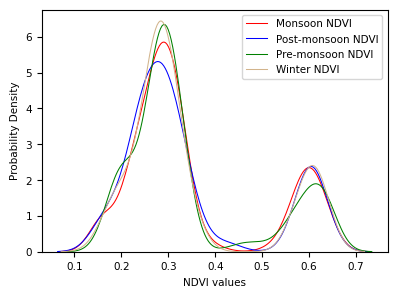

In [12]:
# Plotting the KDE Plot 

plt.figure(figsize=(4, 3), dpi=100)
plt.rcParams['font.size'] = '7.5'
#plt.grid(True)
sns.kdeplot(monsoon['Trend'],color='red', Label='Monsoon NDVI', linewidth=0.75) 
sns.kdeplot(Post_monsoon['trend'],color='blue', Label='Post-monsoon NDVI', linewidth=0.75) 
sns.kdeplot(Pre_monsoon['NDVI'],color='green', Label='Pre-monsoon NDVI', linewidth=0.75) 
sns.kdeplot(Winter_NDVI['trebd'],color='tan', Label='Winter NDVI', linewidth=0.75) 

plt.legend(fontsize='7.5')
                             

plt.xlabel('NDVI values',fontsize='7.5') 
plt.ylabel('Probability Density',fontsize='7.5') 
plt.tight_layout()
plt.savefig("D:/EVI papers/plots for 1988-2020/probability distribution 7 April.jpg")


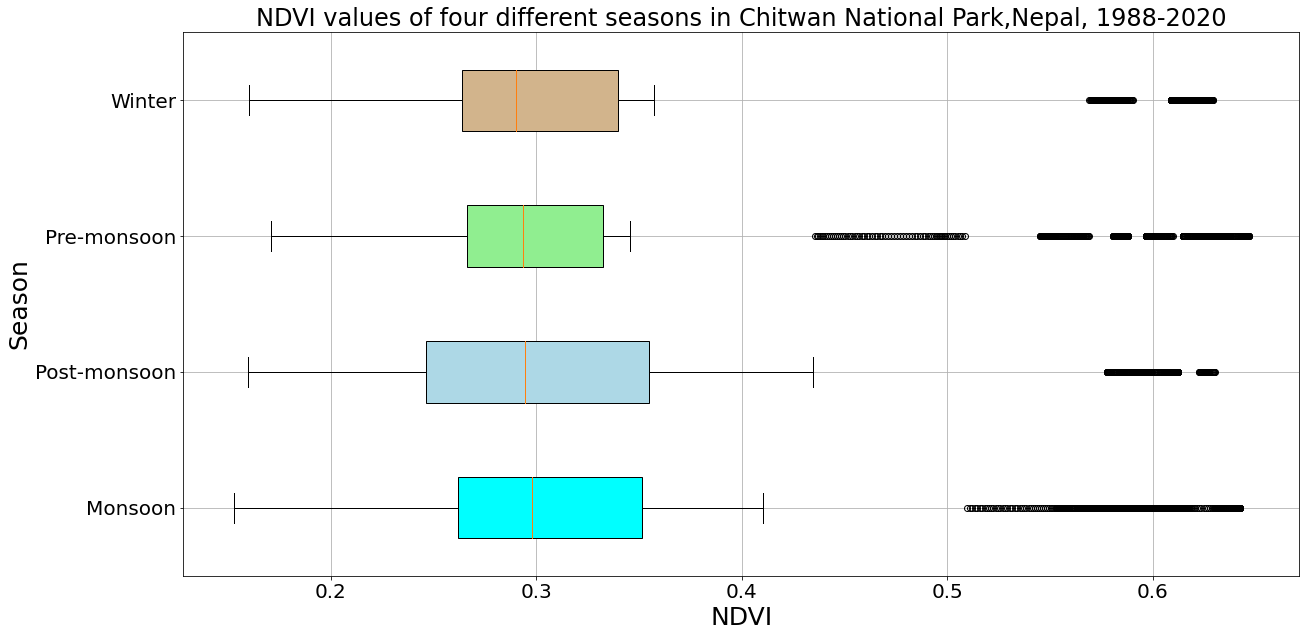

In [13]:
plt.figure(figsize=(20,10))
plt.rcParams['font.size'] = '20'
box_plot_data=[monsoon['Trend'].dropna(),Post_monsoon['trend'].dropna(),Pre_monsoon['NDVI'].dropna(),Winter_NDVI['trebd'].dropna()]
box=plt.boxplot(box_plot_data,vert=0,patch_artist=True,labels=['Monsoon','Post-monsoon','Pre-monsoon','Winter'])
plt.grid(True)
colors = ['cyan', 'lightblue', 'lightgreen', 'tan']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.xlabel('NDVI', fontsize='25')
plt.ylabel('Season', fontsize='25')
plt.title('NDVI values of four different seasons in Chitwan National Park,Nepal, 1988-2020')
plt.savefig("D:/EVI papers/plots for 1988-2020/boxplotsseasons.jpg")
plt.show()

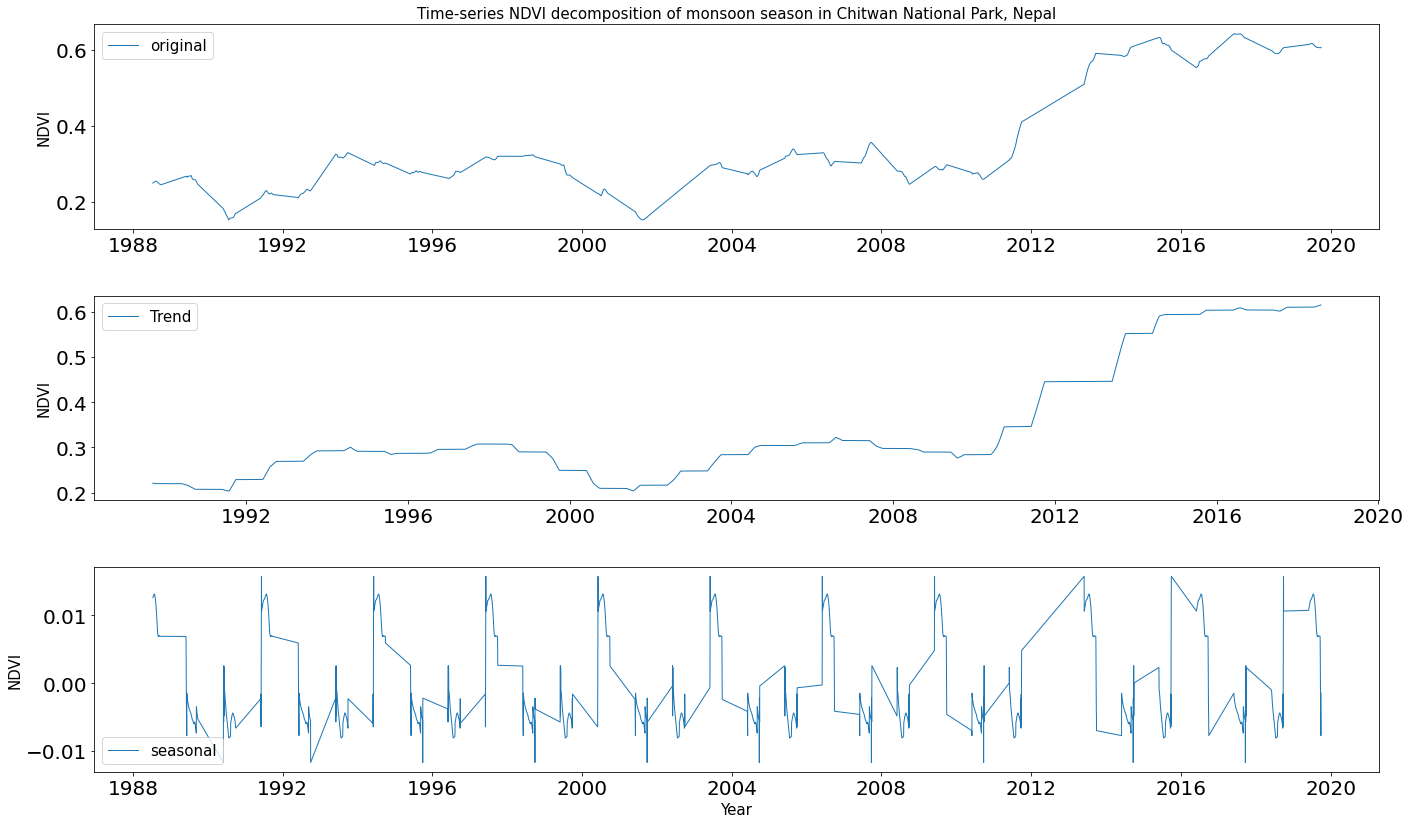

In [14]:
# Apply decompomposition on NDVI data monsoon

decomposition_NDVI = seasonal_decompose(monsoon.dropna(), model= 'additive', period = 365)    # additive worked better in terms of seasonality decomposition
                                                            # compared to multiplicative

# assign trend, seasonal components from decomposed data 

trend_NDVI = decomposition_NDVI.trend
#trend_NDVI.to_csv("D:/EVI papers/plots for 1988-2020/decomndvifrom1988-2020new2.csv")
seasonal_NDVI = decomposition_NDVI.seasonal


# Plot the original data, the trend, the seasonality, and the residual

plt.figure(figsize=(20,15))
plt.subplot(411)
plt.plot(monsoon, label = 'original', linewidth=1)

plt.legend(loc = 'best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.title('Time-series NDVI decomposition of monsoon season in Chitwan National Park, Nepal', fontsize=15)
plt.subplot(412)
plt.plot(trend_NDVI, label = 'Trend', linewidth=1)

plt.legend(loc = 'best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.subplot(413)

plt.plot(seasonal_NDVI, label = 'seasonal', linewidth=1)
plt.legend(loc = 'best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.tight_layout()

plt.savefig("D:/EVI papers/plots for 1988-2020/ndvivaluesfrom1988-2020decomlargenewfinal29octobermonsoon.jpg")
